In [ ]:
# !pip install catboost

In [70]:
#Standard libraries for data analysis:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from scipy import stats
from scipy.stats import skew, norm
import statsmodels.api as sm
import joblib
import pickle

# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

#Modules for Model Selection:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor


#sklearn modules for Model Evaluation & Improvement:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics

#Standard libraries for data visualization:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.express as px
import plotly.tools as tls
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

# 7.1: Import the dataset 'insurance.csv'. 
- The column 'charges' should be considered the target label.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [ ]:
insurance = pd.read_csv('insurance.csv', encoding='Latin-1')
display(insurance.head(), insurance.tail())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


Columns

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance or number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

# 7.2: Explore the data using at least 3 data exploratory tools of your choosing in pandas.

In [ ]:
print(f'The dataset has {insurance.shape[0]} rows and {insurance.shape[1]} columns')

The dataset has 1338 rows and 7 columns


In [ ]:
display(insurance.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

In [ ]:
display(insurance.isnull().any())

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

P/N: No missing or undefined values


In [ ]:
display(insurance.describe(include='all').round())

,age,sex,bmi,children,smoker,region,charges
count,1338.0,1338,1338.0,1338.0,1338,1338,1338.0
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.0,NaN,31.0,1.0,NaN,NaN,13270.0
std,14.0,NaN,6.0,1.0,NaN,NaN,12110.0
min,18.0,NaN,16.0,0.0,NaN,NaN,1122.0
25%,27.0,NaN,26.0,0.0,NaN,NaN,4740.0
50%,39.0,NaN,30.0,1.0,NaN,NaN,9382.0
75%,51.0,NaN,35.0,2.0,NaN,NaN,16640.0


P/N:
- The average age is 39: the youngest is 18, the oldest is 64. 
- Slightly more male participants than females. 
- There's a larger amount of participants from the southeast region.
- The average BMI is 31: minimum BMI is 16, maximum BMI is 53. 
- Majority of the participants are non-smoker. 
- Average insurance charge is 13,270, with less than 50% participants paying above 9,382.

**Univariate Analysis**

---


In [ ]:
binary_features = insurance.nunique()[insurance.nunique() == 2].keys().tolist()
numeric_features = [col for col in insurance.select_dtypes(['float','int']).columns.tolist() if col not in binary_features]
categorical_features = [col for col in insurance.select_dtypes('object').columns.to_list() if col not in binary_features + numeric_features ]

display(binary_features, numeric_features, categorical_features)

['sex', 'smoker']

['age', 'bmi', 'children', 'charges']

['region']

Visualising distribution of categorical variables

In [ ]:
def countplot_ratio(x,data,hue=None,ax=None):
    ax=sns.countplot(x,data=data,hue=hue,ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
    ax.set_title(x + " Distributions")
    ax.legend(bbox_to_anchor=(1.01,1))
    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3, '{:.2f}%'.format((height/total)*100),fontsize=12, weight = 'bold',ha="center") 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


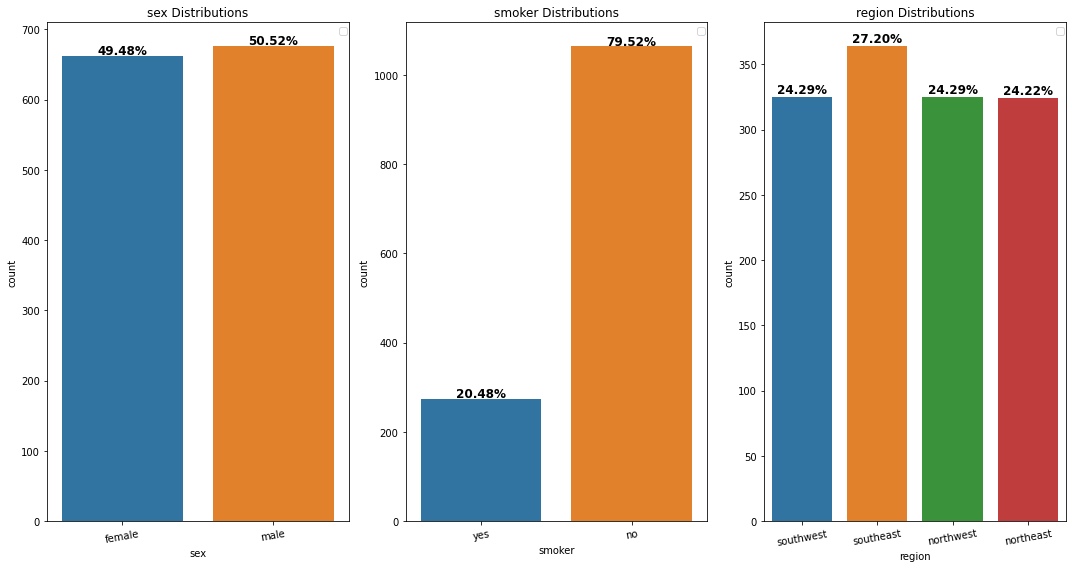

In [ ]:
features = binary_features + categorical_features

fig, axes =plt.subplots(1, 3, figsize=(15, 8),)
axes = axes.flatten()
#fig.suptitle('Distribution of Categorical Features', fontsize=16)

for ax, col in zip(axes, features ):
    countplot_ratio(col, insurance[features], ax=ax)

plt.tight_layout()  
plt.show()

Visualising distribution of numerical vaiables

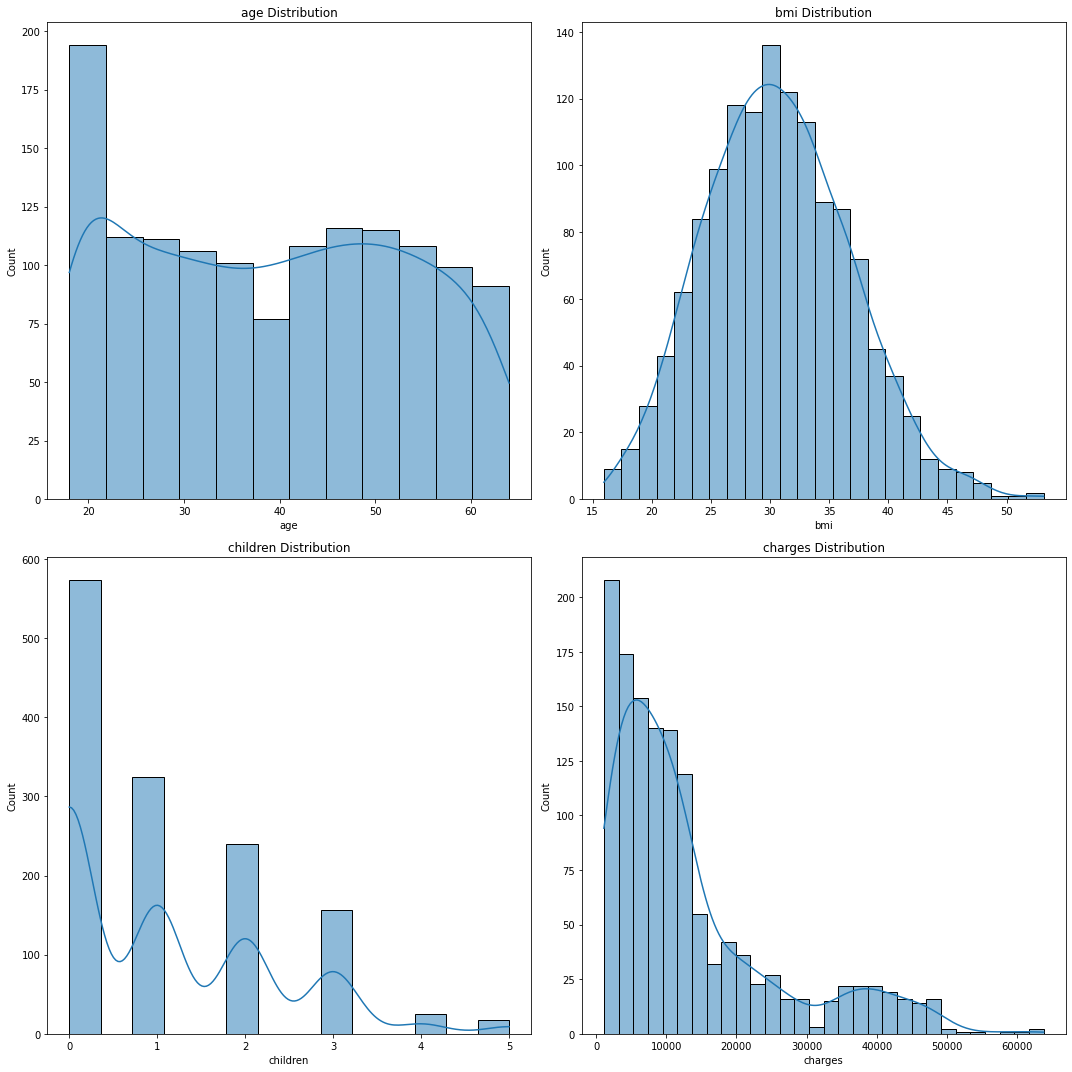

In [ ]:
fig, axes =plt.subplots(2, 2, figsize=(15, 15),)
axes = axes.flatten()
#fig.suptitle('Distribution of Numerical Features', fontsize=16)

for ax, col in zip(axes, numeric_features):
    sns.histplot(data=insurance, x=insurance[col], kde=True, ax=ax, )
    ax.set_title(f'{col} Distribution')

plt.tight_layout()  
plt.show()

**Bivariate Analysis**

---



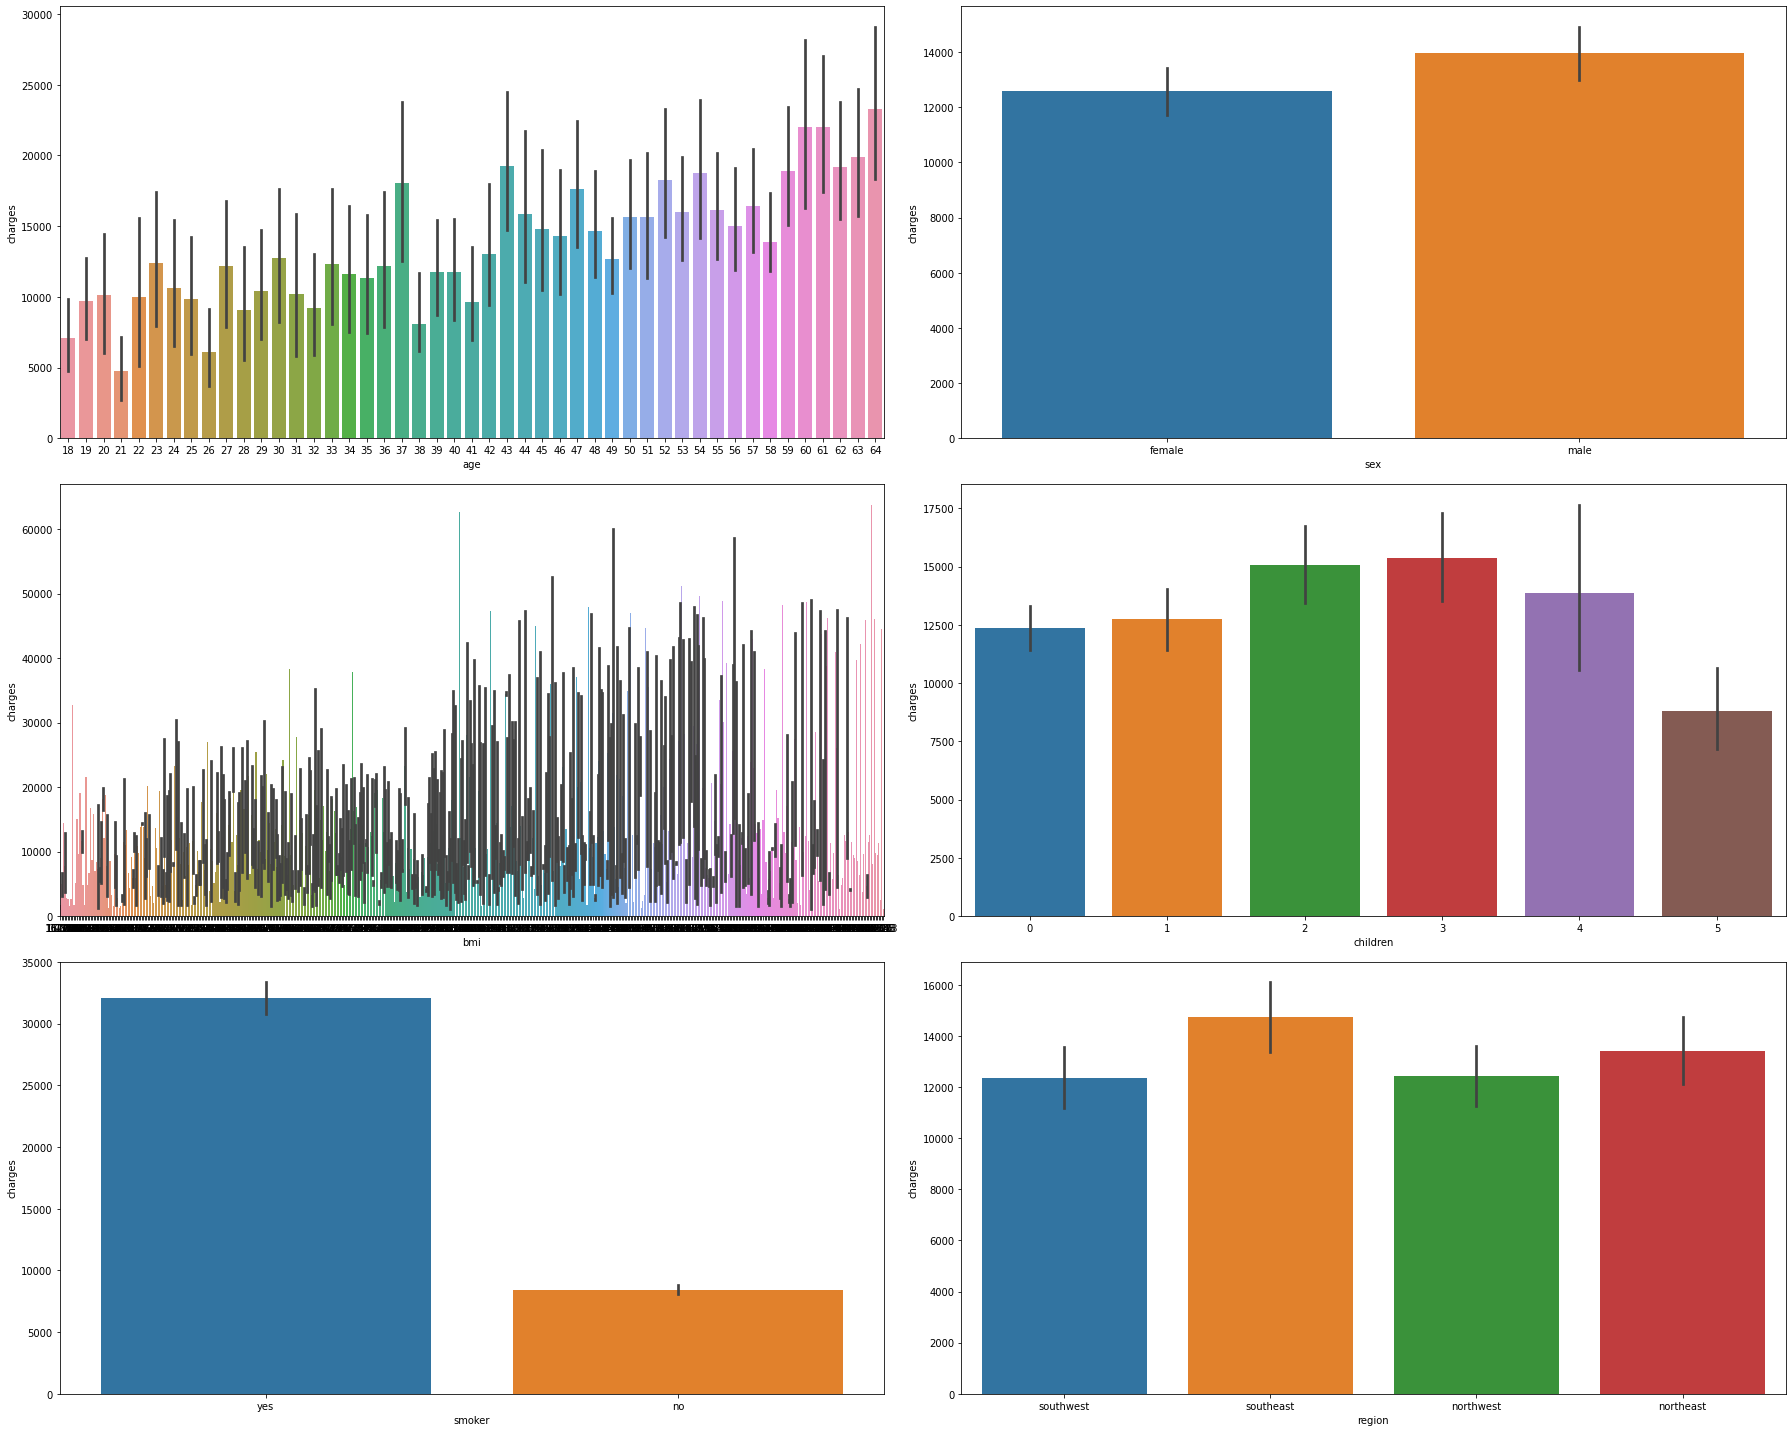

In [ ]:
# Visualising distribution of each variable against the target variable

fig, axes =plt.subplots(3, 2, figsize=(25, 20),)
axes = axes.flatten()
#fig.suptitle('Distribution Features Against the Target Variable(Charges)', fontsize=16)

for ax, col in zip(axes, insurance.columns[:-1]):
    sns.barplot(y=insurance['charges'], x=insurance[col], ax=ax )

plt.tight_layout()  
plt.show()

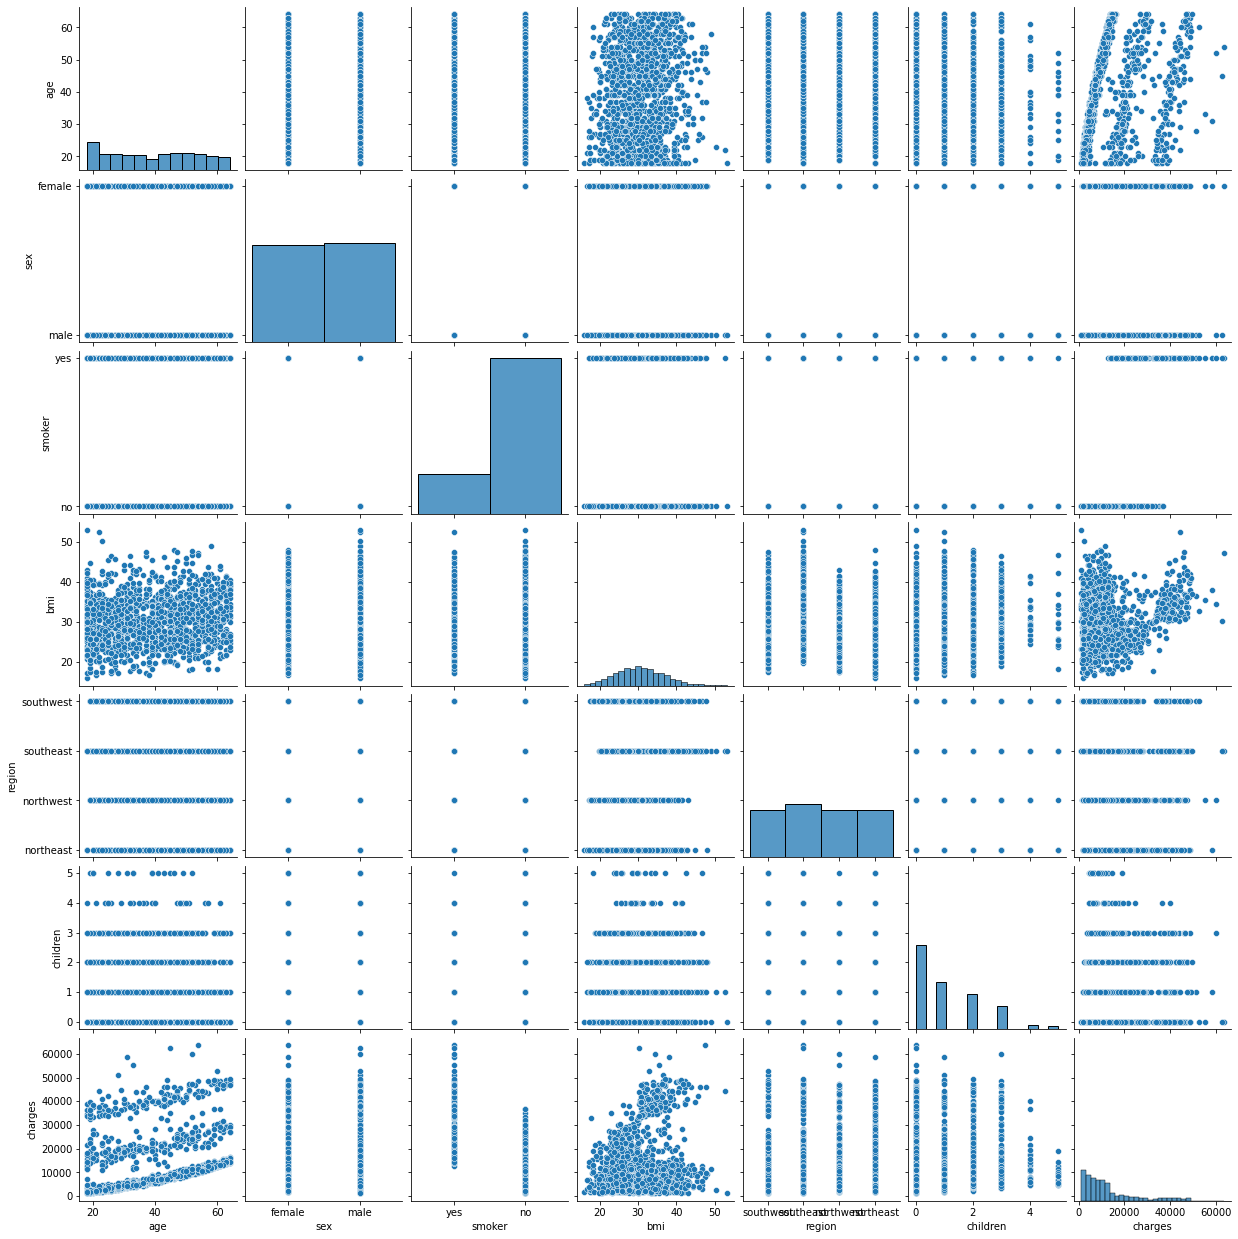

In [ ]:
sns.pairplot(insurance, 
             x_vars=["age", "sex", "smoker", "bmi", "region", "children", "charges", ],
             y_vars=["age", "sex", "smoker", "bmi", "region", "children", "charges", ])

- The pair plot is a quick view of the relationshib between the variables.
- Based on the diagonal plots, a large amount of participants are in their 20s. 
- There are slightly more male participants than female. 
- More than a third of the participants are non-smokers. 
- BMI of all participants seems to be normally distributed, with a mean of approxtimately 30. 
- No. of participants from the different regions are almost uniformly distributed. 
- Most participants are charged below 20,000.

- The Age-Charge graph indicates that as the participant's age increases, the insurance charge increases. 
- From the Gender-BMI graph, it shows that male participants has a wider range of BMI compared to female participants.
- Smoker-Charges plot displays that smokers have a significantly higher insurance charge compared to non-smoker.
- On the BMI-Region plot, participants from southeast has a higher BMI value.

**Correlation**

---



In [ ]:
# label encoding for binary features
encoded_df = insurance.copy()

le = LabelEncoder()
for feature in binary_features:
  encoded_df[feature] = le.fit_transform(encoded_df[feature])
  display(feature, np.unique(encoded_df[feature].values))

encoded_df = pd.get_dummies(encoded_df, columns=categorical_features)
display(encoded_df.head(3))

'sex'

array([0, 1])

'smoker'

array([0, 1])

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,0,0,0,1
1,18,1,33.77,1,0,1725.5523,0,0,1,0
2,28,1,33.00,3,0,4449.4620,0,0,1,0


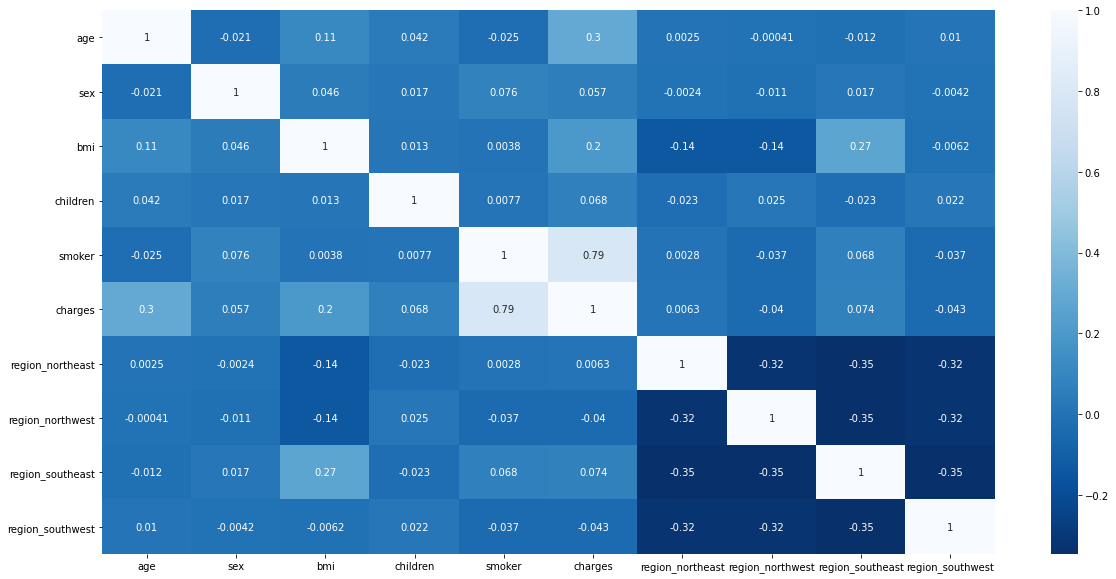

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(encoded_df.corr(), annot = True, cmap = 'Blues_r')

P/N:
- Number of children (dependents) and gender have correlation at minimal, which is 0.068 and 0.057.
- As the number of children is the least influencing factor with all the other variables, a correlation range between 0.0077 to 0.068, this variable shall be excluded in most of the data analysis below.
- Smoker is highly correlated to the insurance charge, with a correlation coefficient of 0.79. 
- Age and BMI are moderately correlated with insurance charge, a correlation coefficient of 0.3 and 0.2. This indicates that the insurance charge will be higher if the person is older or is a smoker or the person has a higher BMI value.

# 7.2(b): Interpret your observation of what form of predictive analysis that can be conducted on the data.

Since the target variable is the continuous variable 'charges', we will need to perform a Regression analysis on it.

# 7.3: Visualize the age distribution for the column 'age' and comment on the results.

In [ ]:
figure = px.histogram(insurance, x='age', color='smoker', hover_data=insurance.columns, color_discrete_sequence=['indianred', 'indigo'], 
                      template='plotly_dark')
figure.show(renderer='colab')

- The analysis suggests that data in the age column is not normally distrubuted with most of the participants being young adults and therefore the data may be biased.

# 7.4: Isolate all the continuous and discrete columns into their respective lists.

In [ ]:
numerical_discrete = [var for var in numeric_features if len(insurance[var].unique()) < 20]
numerical_continuous = [var for var in numeric_features if var not in numerical_discrete]

display(numerical_discrete, numerical_continuous)

['children']

['age', 'bmi', 'charges']

# 7.5: Visually identify if there is presence of any outliers in the numerical_continuous columns and resolve them using a zscore test and a threshold of your choosing.

In [ ]:
for col in insurance[numerical_continuous].columns:
    fig = px.box(insurance, y=insurance[col], title=f'{col} Box Plot Distribution', color_discrete_sequence=['indianred'], 
                 template='plotly_dark' )
    fig.show(renderer='colab')

P/N: There are outliers

In [ ]:
def outlier_detector(data):
    outliers = []
    zscore = []
    threshold = 3
    for i in data:
        score = (i - np.mean(data)) / np.std(data)
        zscore.append(score)
        
        if np.abs(score) > threshold:    
            outliers.append(i)

    return len(outliers), outliers

In [ ]:
num_bmi_outliers, bmi_outliers = outlier_detector(insurance['bmi'])
num_charges_outliers, charges_outliers = outlier_detector(insurance['charges'])
num_age_outliers, age_outliers = outlier_detector(insurance['age'])

display(num_bmi_outliers, bmi_outliers)
display(num_charges_outliers, charges_outliers)
display(num_age_outliers, age_outliers)

4

[49.06, 50.38, 52.58, 53.13]

7

[51194.55914,
 63770.42801,
 58571.074479999996,
 55135.402089999996,
 52590.82939,
 60021.39897,
 62592.87309]

0

[]

In [ ]:
for col in insurance[numerical_continuous].columns:
    zscore = np.abs(stats.zscore(insurance[col]))
    print(f'{col} outlier indexes: {np.where( z > 3 )}')

age outlier indexes: (array([  34,  543,  577,  819, 1146, 1230, 1300]),)
bmi outlier indexes: (array([  34,  543,  577,  819, 1146, 1230, 1300]),)
charges outlier indexes: (array([  34,  543,  577,  819, 1146, 1230, 1300]),)


In [ ]:
zscore = np.abs(stats.zscore(insurance[numerical_continuous]))
display(np.where( zscore > 3 ))

(array([  34,  116,  543,  577,  819,  847, 1047, 1146, 1230, 1300, 1317]),
 array([2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1]))

In [ ]:
insurance_clean = insurance[(zscore < 3).all(axis=1)]

In [ ]:
print(f'Dataset before outlier removal: {insurance.shape}')
print(f'Dataset after outlier removal: {insurance_clean.shape}')

Dataset before outlier removal: (1338, 7)
Dataset after outlier removal: (1327, 7)


#7.6: Validate that your analysis above was successful by visualizing the value distribution in the resulting columns using an appropriate visualization method.

In [ ]:
for col in insurance_clean[numerical_continuous].columns:
    fig = px.box(insurance_clean, y=insurance_clean[col], title=f'{col} Box Plot Distribution After Cleaning', color_discrete_sequence=['gold'], 
                 template='plotly_dark' )
    fig.show(renderer='colab')

- Using the Z-score method we can see that some outliers have been successfully removes however not all have been removed.

# 7.7: Isolate all the categorical column names into a list named 'categorical'.

In [ ]:
categorical = [col for col in insurance.select_dtypes('object').columns]
display(categorical)

['sex', 'smoker', 'region']

# 7.8: Visually identify the outliers in the discrete and categorical features and resolve them using the combined rare levels method.

In [ ]:
features_df = pd.DataFrame()

for col in numerical_discrete + categorical:
    features_df[col] = insurance[col]
features_df.head(3)

,children,sex,smoker,region
0,0,female,yes,southwest
1,1,male,no,southeast
2,3,male,no,southeast


In [ ]:
for col in features_df.columns:
   fig = px.bar(data_frame=features_df, x=features_df[col].unique(), y=features_df[col].value_counts(normalize=True), 
                color_discrete_sequence=['aqua'], template='plotly_dark', title=f'Frequency of {col} Distribution', )
   fig.update_layout( xaxis_title = col, yaxis_title=f'Frequency of Observations per {col}',)
   fig.show(renderer='colab')

In [ ]:
def rare_imputation(data, column):
    #frequencies = data[column].value_counts(normalize=True, ascending=True)
    #frequents = [x for x in frequencies.loc[frequencies > 0.03].index.values]
    
    data[column] = data[column].mask(data[column].map(data[column].value_counts(normalize=True)) < 0.03, 'rare')
    return data[column]

In [ ]:
for col in features_df.columns:
    insurance_clean[col] = rare_imputation(insurance_clean, col)
    print(f'{col}: \n {insurance_clean[col].unique()}')

children: 
 [0 1 3 2 'rare']
sex: 
 ['female' 'male']
smoker: 
 ['yes' 'no']
region: 
 ['southwest' 'southeast' 'northwest' 'northeast']


# 7.9: Encode the discrete and categorical features with one of the measures of central tendency of your choosing.

In [ ]:
'''def target_encoder(df, column, target, index=None, method='median'):
    """
    Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal
    with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable
    with just one new numerical variable. Each category or level of the categorical variable is represented by a
    summary statistic of the target for that level.
    Args:
        df (pandas df): Pandas DataFrame containing the categorical column and target.
        column (str): Categorical variable column to be encoded.
        target (str): Target on which to encode.
        index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold
        method (str): Summary statistic of the target. Mean, median or std. deviation.
    Returns:
        arr: Encoded categorical column.
    """

    index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied

    if method == 'mean':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].mean())
    elif method == 'median':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].median())
    elif method == 'std':
        encoded_column = df[column].map(df.iloc[index].groupby(column)[target].std())
    else:
        raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))

    return encoded_column'''

In [ ]:
def target_encoder(data, feature, target='charges'):
    ordered_labels = data.groupby([feature])[target].mean().to_dict()
    data[feature] = data[feature].map(ordered_labels)

    return data[feature]

In [ ]:
for col in features_df.columns:
    insurance_clean[col] = target_encoder(insurance_clean, col, target='charges')
    print(f'{col}: \n {insurance_clean[col].value_counts()}')

display(insurance_clean.head(3), insurance_clean.tail(3))

children: 
 12062.386751    568
12400.608083    320
15073.563734    240
15068.997337    156
11730.582377     43
Name: children, dtype: int64
sex: 
 13695.927985    668
12357.487542    659
Name: sex, dtype: int64
smoker: 
 8443.994935     1061
31328.517137     266
Name: smoker, dtype: int64
region: 
 14463.246427    358
12102.072010    323
12137.941782    323
13266.555755    323
Name: region, dtype: int64


,age,sex,bmi,children,smoker,region,charges
0,19,12357.487542,27.90,12062.386751,31328.517137,12102.072010,16884.9240
1,18,13695.927985,33.77,12400.608083,8443.994935,14463.246427,1725.5523
2,28,13695.927985,33.00,15068.997337,8443.994935,14463.246427,4449.4620


,age,sex,bmi,children,smoker,region,charges
1335,18,12357.487542,36.85,12062.386751,8443.994935,14463.246427,1629.8335
1336,21,12357.487542,25.80,12062.386751,8443.994935,12102.072010,2007.9450
1337,61,12357.487542,29.07,12062.386751,31328.517137,12137.941782,29141.3603


# 7.10. Separate your features from the target appropriately. Narrow down the number of features to 5 using the most appropriate and accurate method. Which feature had to be dropped and what inference would you give as the main contributor of dropping the given feature.

**Uncoverring Features Importance**

---



In [ ]:
X = insurance_clean.drop(columns='charges')
y = insurance_clean['charges']
display(X.head(3), y.head(3))

,age,sex,bmi,children,smoker,region
0,19,12357.487542,27.90,12062.386751,31328.517137,12102.072010
1,18,13695.927985,33.77,12400.608083,8443.994935,14463.246427
2,28,13695.927985,33.00,15068.997337,8443.994935,14463.246427


0    16884.9240
1     1725.5523
2     4449.4620
Name: charges, dtype: float64

In [ ]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV()
rr = ridge.fit(X, y)
r2_score = rr.score(X, y)  
print(f'Best alpha : {rr.alpha_}')
print(f'Intercept c = {rr.intercept_}')
print(f'Coefficients m of each of the features = {rr.coef_}')
print(f'coefficient of determination = {r2_score}')

Best alpha : 10.0
Intercept c = -24002.35595129127
Coefficients m of each of the features = [ 2.55488297e+02 -4.52214525e-02  3.08835320e+02  4.24778221e-01
  1.00927893e+00 -4.02359626e-02]
coefficient of determination = 0.7512562312010491


In [ ]:
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient':np.transpose(rr.coef_)}).sort_values(by='Coefficient', 
                                                                                                         ascending=False)
coefficients_df

,Feature,Coefficient
2,bmi,308.835320
0,age,255.488297
4,smoker,1.009279
3,children,0.424778
5,region,-0.040236
1,sex,-0.045221


In [ ]:
figure = px.pie(coefficients_df, names='Feature', values='Coefficient', color='Feature', color_discrete_sequence=px.colors.sequential.RdBu,
                title='Ridge Regression Coefficient Weights', template='plotly_dark')
    
figure.show(renderer='colab')

- Notice the absence of 'sex' due to it's negative coeffficients.
- According to this analysis, 'bmi' has the most weight, while 'sex' has the least weight.
- I will be dropping the sex feature since it has the least weights implying that it contributes least to the target variable and therefore is the least important feature.


#**Assignment 8**

#8.1: Convert the target labels to their respective log values and give 2 reasons why this step may be useful as we train the machine learning model.

In [ ]:
X = X.drop(columns='sex')
y_log = np.log10(y)

display(X.head(2), y_log.head(2))

,age,bmi,children,smoker,region
0,19,27.90,12062.386751,31328.517137,12102.072010
1,18,33.77,12400.608083,8443.994935,14463.246427


0    4.227499
1    3.236928
Name: charges, dtype: float64

1. Reducing Skewness: Logarithmic transformations transform a highly skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively. In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve i.e it reduces or removes the skewness in the dataset.

2. Convenience: 
- A transformed scale may be as natural as the original scale and more convenient for a specific purpose (e.g. percentages rather than original data, sines rather than degrees). One important example is standardization.
- Linear relationships: When looking at relationships between variables, it is often far easier to think about patterns that are approximately linear than about patterns that are highly curved.
- Additive relationships: Relationships are often easier to analyse when additive rather than multiplicative.
- Equal spreads: A transformation may be used to produce approximately equal spreads, despite marked variations in level, which again makes data easier to handle and interpret.

# 8.2: Slice the selected feature columns and the labels into the training and testing set. Also ensure your features are normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
# transformer = ColumnTransformer([("scaler", scaler, X_train.columns)], remainder="passthrough")
Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.transform(X_test)

# 8.3: Use at least 4 different regression based machine learning methods and use the training and testing cross accuracy and divergence to identify the best model.

In [ ]:
def val_model(X, y, regressor, quiet=False):
    """
    Cross-validates a given model

    # Arguments
      X: DataFrame, feature matrix
      y: Series, target vector
      regressor: regression model from scikit-learn
      quiet: Boolean, indicates if funcion should print the results

    # Returns
      Float, r2 validation scores
  """

    X = np.array(X)
    y = np.array(y)

    #pipe = make_pipeline(MinMaxScaler(), regressor)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(regressor, X, y, cv=kfold, scoring='r2')

    if quiet == False:
        print(f"##### {regressor.__class__.__name__} #####")
        print(f'Scores: {scores}')
        print(f'R2: {scores.mean()} (+/- {scores.std()})')

    return scores.mean()

In [ ]:
def getRegR2Scores(X_train, y_train, *reg_list):
    """
     Provides the R2 scores for a given list of models
    
    # Arguments
     X_train: X_train
     y_train: y_train
     *reg_list: list of regressors

    # Returns
     DataFrame, r2 scores

  """

    model = []
    r2 = []

    for reg in reg_list:
        model.append(reg.__class__.__name__)
        r2.append(val_model(X_train, y_train, reg))

    return pd.DataFrame(data=r2, index=model, columns=['R2']).sort_values(by='R2', ascending=False)

In [ ]:
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()
random = RandomForestRegressor()
svr = SVR()
xgb = XGBRegressor()
sgd = SGDRegressor()
ada = AdaBoostRegressor()
#cat = CatBoostRegressor
#lg = LGBMRegressor
#gb = GradientBoostingRegressor

regressors = [lr, lasso, ridge, elastic, random, svr, xgb, sgd, ada]

In [ ]:
scores_df = getRegR2Scores(Xtrain_scaled, y_train, *regressors)
display(scores_df)

##### LinearRegression #####
Scores: [0.74562296 0.7301636  0.7407993  0.7721251  0.82896831]
R2: 0.7635358553184433 (+/- 0.035515382324395446)
##### Lasso #####
Scores: [-0.00073319 -0.00054137 -0.00106822 -0.00252523 -0.0006093 ]
R2: -0.00109546255753199 (+/- 0.0007375061496637361)
##### Ridge #####
Scores: [0.74692929 0.7306451  0.7407818  0.77121816 0.82801527]
R2: 0.7635179241773451 (+/- 0.034905409140663986)
##### ElasticNet #####
Scores: [-0.00073319 -0.00054137 -0.00106822 -0.00252523 -0.0006093 ]
R2: -0.00109546255753199 (+/- 0.0007375061496637361)
##### RandomForestRegressor #####
Scores: [0.82178863 0.7570906  0.79495101 0.82611954 0.88358799]
R2: 0.8167075532762293 (+/- 0.04150885433296307)
##### SVR #####
Scores: [0.80636483 0.77062861 0.81031506 0.84795027 0.90903186]
R2: 0.8288581254271274 (+/- 0.046974052030015076)
[06:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:32] WARNING: /workspace

,R2
XGBRegressor,0.844553
SVR,0.828858
RandomForestRegressor,0.816708
LinearRegression,0.763536
Ridge,0.763518
AdaBoostRegressor,0.752488
SGDRegressor,0.650732
Lasso,-0.001095
ElasticNet,-0.001095


- From the above analysis the Extreme Gradient Boosting Regressor is the model with the highest average R2 score and I will be using it for my predictive analysis

#8.4: After identifying the best model, train it with the training data again. 

In [50]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, seed=42)
model.fit(Xtrain_scaled, y_train, eval_set=[(Xtest_scaled, y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

b): Using at least 3 model evaluation metrics in regression, evaluate the models training and testing score. Also ensure as you test the models, the predicted and actual targets have been converted back to the original values.

In [74]:

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    y_train_exp, y_test_exp, train_pred_exp, y_pred_exp = np.exp(y_train), np.exp(y_test), np.exp(train_pred), np.exp(y_pred)

    scores = { "Train MAE": mean_absolute_error(y_train_exp, train_pred_exp),
              "Test MAE": mean_absolute_error(y_test_exp, y_pred_exp),
              
              "Train RMSLE": rmsle(y_train_exp, train_pred_exp),
              "Test RMSLE": rmsle(y_test_exp, y_pred_exp),
              
              "Train R^2": r2_score(y_train_exp, train_pred_exp),
              "Test R^2": r2_score(y_test_exp, y_pred_exp) }

    return scores

In [75]:
show_scores(model, Xtrain_scaled, Xtest_scaled, y_train, y_test)

{'Test MAE': 5.468439923654442,
 'Test RMSLE': 0.20435906691478825,
 'Test R^2': 0.7546777287148608,
 'Train MAE': 2.9876764078176516,
 'Train RMSLE': 0.09185070290942025,
 'Train R^2': 0.9313714737860721}